<a href="https://colab.research.google.com/github/garbesc/Projet-6/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# Import des librairies
import numpy as np
import pandas as pd
import os, sys, time
import math, random
import h5py
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
#from skimage import io

import tensorflow as tf
print ("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
%%time
# Contrôle du format des fichiers images
folder_path = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Images/"
files_list = []
for path, dirs, files in os.walk(folder_path):
    for filename in files:
        if (filename.endswith("jpg") & ~filename.endswith("(1).jpg")):
            try:
                fobj = open(path+"/"+filename, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            except:
                continue
            finally:
                fobj.close()

            if is_jfif:
#                print (str(path.replace(folder_path,"")) + " " + str(filename.replace(".jpg","")))
                files_list.append([path.replace(folder_path,""), filename.replace(".jpg","")])
            else:
                os.remove(path+"/"+filename)
                os.remove(path.replace("Images","Annotation")+"/"+filename.replace('.jpg',''))  

CPU times: user 1.23 s, sys: 1.72 s, total: 2.95 s
Wall time: 25.8 s


In [79]:
print (len(files_list))
df=pd.DataFrame(files_list,columns=['folder','filename'])

20570


In [80]:
%%time
annot_path = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Annotation/"
for path, dirs, files in os.walk(annot_path):
    for filename in files:
        if filename.startswith("n"):
            tree = et.parse(path+"/"+filename)
            df.loc[(df['filename']==filename),['width']]  = int(tree.getroot().findall('size')[0].find('width').text)
            df.loc[(df['filename']==filename),['height']] = int(tree.getroot().findall('size')[0].find('height').text)
            df.loc[(df['filename']==filename),['depth']]  = int(tree.getroot().findall('size')[0].find('depth').text)
            df.loc[(df['filename']==filename),['name']]   = tree.getroot().findall('object')[0].find('name').text
            df.loc[(df['filename']==filename),['pose']]   = tree.getroot().findall('object')[0].find('pose').text
            df.loc[(df['filename']==filename),['truncated']] = int(tree.getroot().findall('object')[0].find('truncated').text)
            df.loc[(df['filename']==filename),['difficult']] = int(tree.getroot().findall('object')[0].find('difficult').text)
            df.loc[(df['filename']==filename),['xmin']] = \
               int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            df.loc[(df['filename']==filename),['xmax']] = \
               int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            df.loc[(df['filename']==filename),['ymin']] = \
               int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            df.loc[(df['filename']==filename),['ymax']] = \
               int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)

CPU times: user 10min 33s, sys: 4.84 s, total: 10min 38s
Wall time: 11min 7s


In [81]:
df

,folder,filename,width,height,depth,name,pose,truncated,difficult,xmin,xmax,ymin,ymax
0,n02090622-borzoi,n02090622_2337,225.0,243.0,3.0,borzoi,Unspecified,0.0,0.0,38.0,220.0,17.0,242.0
1,n02090622-borzoi,n02090622_1047,500.0,333.0,3.0,borzoi,Unspecified,0.0,0.0,140.0,296.0,2.0,331.0
2,n02090622-borzoi,n02090622_10302,500.0,366.0,3.0,borzoi,Unspecified,0.0,0.0,168.0,499.0,62.0,365.0
3,n02090622-borzoi,n02090622_10281,500.0,423.0,3.0,borzoi,Unspecified,0.0,0.0,48.0,454.0,26.0,402.0
4,n02090622-borzoi,n02090622_1391,363.0,500.0,3.0,borzoi,Unspecified,0.0,0.0,51.0,262.0,307.0,498.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20565,n02105056-groenendael,n02105056_7355,500.0,333.0,3.0,groenendael,Unspecified,0.0,0.0,212.0,475.0,20.0,332.0
20566,n02105056-groenendael,n02105056_98,352.0,500.0,3.0,groenendael,Unspecified,0.0,0.0,31.0,263.0,98.0,413.0
20567,n02105056-groenendael,n02105056_7381,357.0,500.0,3.0,groenendael,Unspecified,0.0,0.0,46.0,326.0,32.0,483.0
20568,n02105056-groenendael,n02105056_933,166.0,220.0,3.0,groenendael,Unspecified,0.0,0.0,20.0,165.0,10.0,219.0


In [ ]:
df.drop(df[df.filename.str.endswith("(1)")].index,axis=0, inplace=True)

In [ ]:
df.width.describe()

count    20570.000000
mean       442.455177
std        142.525013
min         97.000000
25%        361.000000
50%        500.000000
75%        500.000000
max       3264.000000
Name: width, dtype: float64

In [ ]:
df.height.describe()

count    20570.000000
mean       385.830141
std        124.728289
min        100.000000
25%        333.000000
50%        375.000000
75%        453.000000
max       2562.000000
Name: height, dtype: float64

In [ ]:
# Contrôle de la largeur / hauteur
df.loc[(df.width<=256)| (df.height<=256)]

,folder,filename,width,height,depth,name,pose,truncated,difficult,xmin,xmax,ymin,ymax
0,n02090622-borzoi,n02090622_2337,225.0,243.0,3.0,borzoi,Unspecified,0.0,0.0,38.0,220.0,17.0,242.0
21,n02090622-borzoi,n02090622_4797,283.0,243.0,3.0,borzoi,Unspecified,0.0,0.0,19.0,267.0,16.0,234.0
29,n02090622-borzoi,n02090622_3300,250.0,173.0,3.0,borzoi,Unspecified,0.0,0.0,32.0,206.0,11.0,166.0
31,n02090622-borzoi,n02090622_4873,231.0,227.0,3.0,borzoi,Unspecified,0.0,0.0,66.0,219.0,97.0,217.0
36,n02090622-borzoi,n02090622_3763,250.0,216.0,3.0,borzoi,Unspecified,0.0,0.0,0.0,220.0,40.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20498,n02105056-groenendael,n02105056_4766,350.0,249.0,3.0,groenendael,Unspecified,0.0,0.0,19.0,349.0,0.0,248.0
20531,n02105056-groenendael,n02105056_5365,314.0,235.0,3.0,groenendael,Unspecified,0.0,0.0,0.0,263.0,22.0,234.0
20553,n02105056-groenendael,n02105056_6899,190.0,290.0,3.0,groenendael,Unspecified,0.0,0.0,41.0,172.0,21.0,269.0
20561,n02105056-groenendael,n02105056_961,240.0,165.0,3.0,groenendael,Unspecified,0.0,0.0,34.0,239.0,17.0,164.0


In [ ]:
# Contrôle de la difficulté et du nombre de couleurs
print (df.loc[df.difficult>0])
print (df.loc[df.depth!=3])

Empty DataFrame
Columns: [folder, filename, width, height, depth, name, pose, truncated, difficult, xmin, xmax, ymin, ymax]
Index: []
Empty DataFrame
Columns: [folder, filename, width, height, depth, name, pose, truncated, difficult, xmin, xmax, ymin, ymax]
Index: []


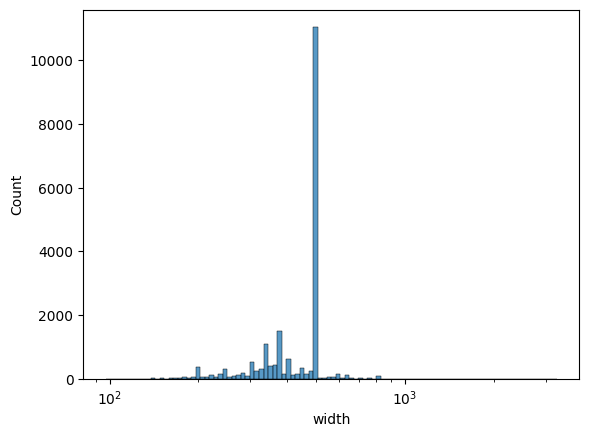

In [ ]:
# Statistiques sur la largeur
sns.histplot(data=df, x="width", bins=100, log_scale=True)
plt.show()

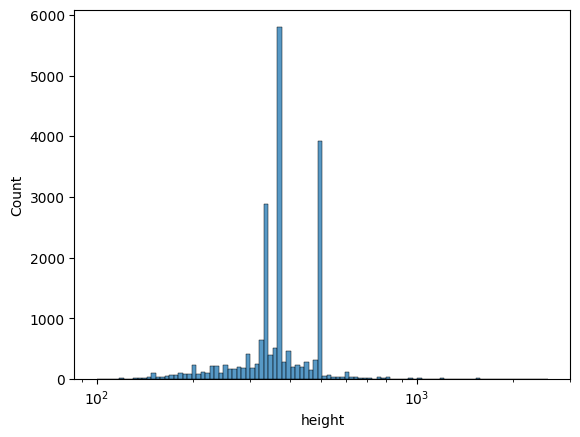

In [ ]:
# Statistiques sur la hauteur
sns.histplot(data=df, x="height", bins=100, log_scale=True)
plt.show()

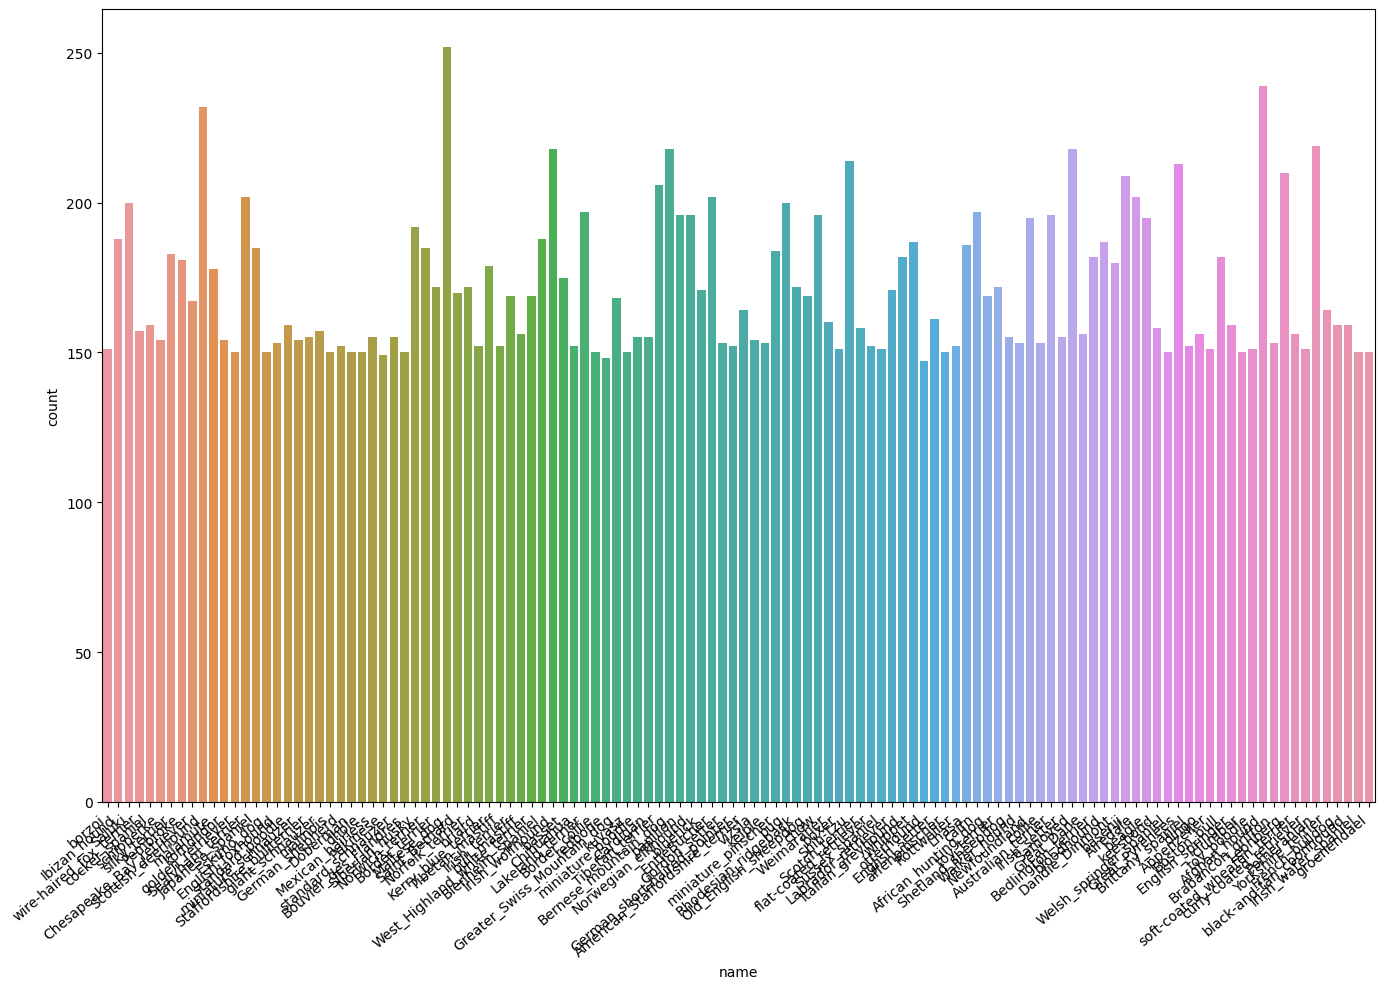

In [ ]:
# Statistiques sur les races
plt.figure(figsize=(14,10))
ax = sns.countplot(data=df, x="name")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

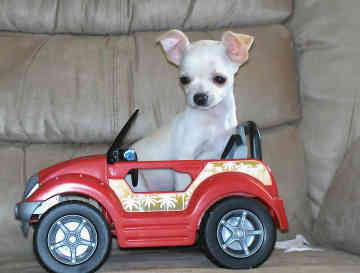

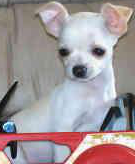

In [ ]:
# Recadrage des images (cropping)
# exemple
file_test = folder_path + "/n02085620-Chihuahua/n02085620_2937.jpg"
image_test = Image.open(file_test)
image_test.show()
image_cropped = image_test.crop((121, 28, 256, 192))
image_cropped.show()



In [82]:
cropped_path = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Images_cropped/"
if not os.path.exists(cropped_path):
  os.makedirs(cropped_path)
 
for path, dirs, files in os.walk(folder_path):
  for filename in files:
    if (filename.endswith("jpg") & ~filename.endswith("(1).jpg")):
      image = Image.open(path+"/"+filename)
      coord = df.loc[df['filename']==filename.replace(".jpg", ""), ['xmin', 'ymin','xmax', 'ymax']].values
      xmin, ymin, xmax, ymax = coord[0]
      image_cropped = image.crop((xmin, ymin, xmax, ymax))
      cropped_spath = path.replace("Images","Images_cropped")
      if not os.path.exists(cropped_spath):
        os.makedirs(cropped_spath)
      image_cropped.save(cropped_spath + "/" +filename)